# Met Office COVID-19 response dataset

This dataset is created, curated and updated for researchers looking to understand links between COVID-19 and environmental factors. 

For more information check out our [blog post](https://medium.com/informatics-lab/met-office-and-partners-offer-data-and-compute-platform-for-covid-19-researchers-83848ac55f5f) and the [data readme](https://metdatasa.blob.core.windows.net/covid19-response/README_data.html)

We are constantly updating the available data, [subscribe to our news group](https://groups.google.com/forum/#!forum/met-office-covid-19-data-and-platform-updates/join) to stay up to date or [contact us](mailto:covid19@informaticslab.co.uk) if you have any requests.

This Notebook offers some examples of how to interact with the data but if you need any help please contact covid19@informaticslab.co.uk.


## Imports and globals
Import the required modules, set up the default plot size and set some constants

In [51]:
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, ContentSettings

from IPython.display import Markdown
import matplotlib.pyplot as plt 
%matplotlib inline 
import datetime
from collections import namedtuple
plt.rcParams['figure.figsize'] = (20.0, 10.0)
import os

## Set up the blob client with the connection details

In [3]:
ACCOUNT_URL="https://metdatasa.blob.core.windows.net"
CONTAINER='covid19-response'

In [4]:
# Create the BlobServiceClient object which will be used to create a container client
blob_service_client = BlobServiceClient(ACCOUNT_URL)
container_client = blob_service_client.get_container_client(CONTAINER)

## Get a particular file based on the data required

The filenames are predictable, if you know what data you want you can download that file

In [5]:
DATA_END = (datetime.datetime.now() - datetime.timedelta(days=9)).date()
DATA_START = datetime.date(2020,1,1)

def url_from_propertys(model, param, freq, stat=None, day=None, hour=None):
    assert model in ["global","ukv"]
    assert param in ["rain", "sh", "snow", "t1o5m", "pmsl","precip","sw"]
    assert freq in ["daily","hourly"]
    if freq == 'daily':
        assert stat in ['max', 'min', 'mean']
    else:
        assert stat is None  
    assert DATA_START <= day <= DATA_END
    
    stat = '_'+stat if stat else ''

    filepath = f'metoffice_{model}_{freq}/{param}{stat}/{model}_{freq}_{param}{stat}_{day:%Y%m%d}.nc'
    return f"{ACCOUNT_URL}/{CONTAINER}/{filepath}"


Properties = namedtuple('Properties',["model","param","freq","stat","day"])

In [6]:

files = [
    Properties("global","precip","daily","mean",datetime.date(2020,3,3)),
    Properties("ukv","t1o5m","daily","min",datetime.date(2020,4,1)),
    Properties("ukv","snow","hourly",None,datetime.date(2020,2,2)),
]

for file in files:
    path = url_from_propertys(*file)
    print(path)

https://metdatasa.blob.core.windows.net/covid19-response/metoffice_global_daily/precip_mean/global_daily_precip_mean_20200303.nc
https://metdatasa.blob.core.windows.net/covid19-response/metoffice_ukv_daily/t1o5m_min/ukv_daily_t1o5m_min_20200401.nc
https://metdatasa.blob.core.windows.net/covid19-response/metoffice_ukv_hourly/snow/ukv_hourly_snow_20200202.nc


## xarray or Iris are useful tools for interacting with this sort of data

In [7]:
import xarray as xr

Stream blob into memory and load dataset in xarray

In [8]:
from io import BytesIO
# TODO: how to read more than one day easily?
data_description = Properties("global","precip","daily","mean",datetime.date(2020,1,30))

In [9]:
file_data = BytesIO(BlobClient.from_blob_url(url_from_propertys(*data_description)).download_blob().readall())

In [10]:
ds = xr.open_dataset(file_data).rename({'longitude':'lon','latitude':'lat'})
ds

<xarray.Dataset>
Dimensions:                       (bnds: 2, lat: 1920, lon: 2560)
Coordinates:
  * lat                           (lat) float32 -89.953125 ... 89.953125
  * lon                           (lon) float32 0.0703125 0.2109375 ... 359.9297
    forecast_period               timedelta64[ns] ...
    forecast_reference_time       datetime64[ns] ...
    time                          datetime64[ns] ...
Dimensions without coordinates: bnds
Data variables:
    precipitation_flux            (lat, lon) float32 ...
    latitude_longitude            int32 ...
    forecast_period_bnds          (bnds) float64 ...
    forecast_reference_time_bnds  (bnds) datetime64[ns] ...
    time_bnds                     (bnds) datetime64[ns] ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   11.2
    Conventions:  CF-1.5

Plot it

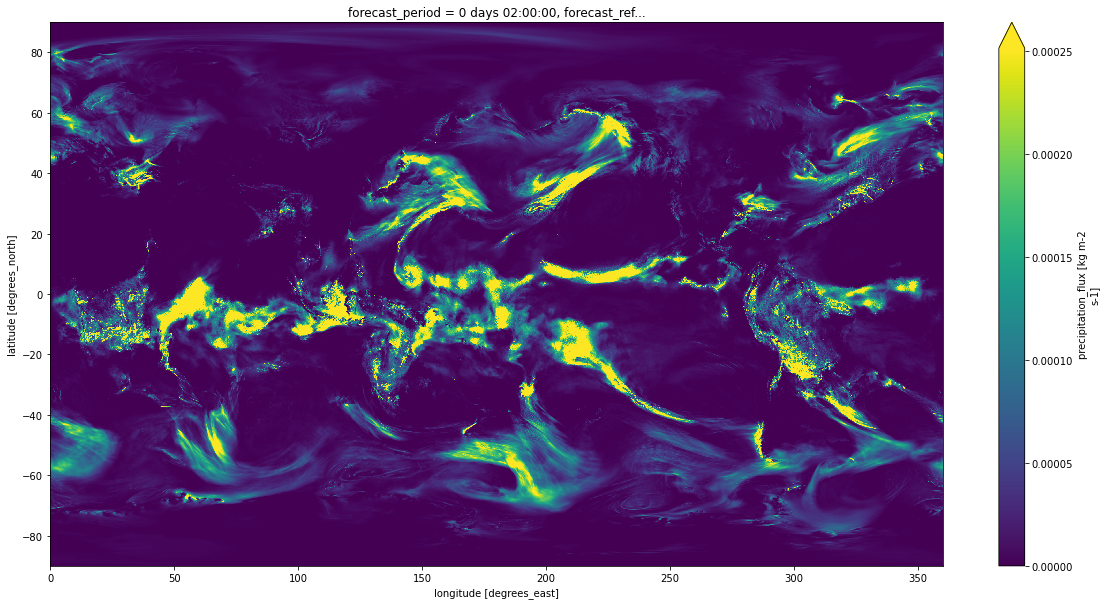

In [12]:
ds.precipitation_flux.plot(robust=True)

With Iris. Use a temporary file as Iris can not read files from memory.

In [18]:
import regionmask

import geopandas

In [48]:
# TODO: wrap into yaml file
# also add region.from_geopandas names abbrevs ... info for each country
country_dict = {'UK':
                    {'base':'https://metdatasa.blob.core.windows.net/covid19-response/shapefiles/England',
                    'name' : 'Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BUC'}
               }

In [52]:
def download_shapefile(country):
    name=country_dict[country]['name']
    base=country_dict[country]['base']
    for ending in ['shx','dbf','shp']:
        filename = f"{name}.{ending}"
        url = f'{base}/{filename}'
        with open(filename, "wb") as f:
            print(f'Download {url} to {filename}')
            data = BlobClient.from_blob_url(url).download_blob()
            data.readinto(f)

In [59]:
country='UK'
filename = country_dict[country]['name']+'.shp'
if not os.path.exists(filename):
    download_shapefile(country)
gdf = geopandas.read_file(filename)
# os.remove(country_dict[country]['name']+)
gdf.head()

,FID,objectid,ctyua19cd,ctyua19nm,ctyua19nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,Shape__Are,Shape__Len,geometry
0,1,1,E06000001,Hartlepool,None,447157,531476,-1.27023,54.676159,9.651231e+07,50488.387081,2.881478e+08,87219.641836,"POLYGON ((-1.17763 54.69919, -1.17398 54.69182..."
1,2,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.544670,5.522915e+07,35506.404054,1.638873e+08,61148.819845,"POLYGON ((-1.28263 54.56528, -1.26256 54.57029..."
2,3,3,E06000003,Redcar and Cleveland,None,464359,519597,-1.00611,54.567520,2.484090e+08,79150.715938,7.373651e+08,136334.504906,"POLYGON ((-1.14913 54.61433, -1.15462 54.62750..."
3,4,4,E06000004,Stockton-on-Tees,None,444937,518183,-1.30669,54.556911,2.052315e+08,87566.678920,6.095007e+08,150910.462698,"POLYGON ((-1.28263 54.56528, -1.27061 54.55602..."
4,5,5,E06000005,Darlington,None,428029,515648,-1.56835,54.535339,1.988128e+08,91926.839545,5.901079e+08,158350.769111,"POLYGON ((-1.69693 54.53601, -1.70527 54.54917..."


In [47]:
# create region with regionmask
%time UK_regions = regionmask.from_geopandas(gdf,names='ctyua19nm',abbrevs='ctyua19cd',name='UK regions')

CPU times: user 15.2 ms, sys: 1.4 ms, total: 16.6 ms
Wall time: 14.4 ms


In [50]:
%time uk_regions_masked = UK_regions.mask(ds)

CPU times: user 1min 23s, sys: 3.23 s, total: 1min 26s
Wall time: 1min 26s


In [54]:
# groupby masked regions
%time precip_regions = ds.groupby(uk_regions_masked).mean('stacked_lat_lon')

CPU times: user 533 ms, sys: 257 ms, total: 790 ms
Wall time: 789 ms


In [55]:
def set_labels(ds,region):
    abbrevs = region[ds.region.values].abbrevs
    names = region[ds.region.values].names

    ds.coords['abbrevs'] = ('region', abbrevs)
    ds.coords['names'] = ('region', names)
    return ds

In [56]:
precip_regions = set_labels(precip_regions,UK_regions)

In [58]:
precip_regions

<xarray.Dataset>
Dimensions:                  (bnds: 2, region: 141)
Coordinates:
    forecast_reference_time  datetime64[ns] 2020-01-30T09:00:00
    time                     datetime64[ns] 2020-01-30T11:00:00
    forecast_period          timedelta64[ns] 02:00:00
  * region                   (region) float64 0.0 1.0 2.0 ... 170.0 171.0 172.0
    abbrevs                  (region) <U9 'E06000001' ... 'W06000024'
    names                    (region) <U35 'Hartlepool' ... 'Merthyr Tydfil'
Dimensions without coordinates: bnds
Data variables:
    precipitation_flux       (region) float32 1.5894572e-07 ... 2.861023e-05
    latitude_longitude       (region) float64 -2.147e+09 ... -2.147e+09
    forecast_period_bnds     (region, bnds) float64 -1.0 5.0 -1.0 ... -1.0 5.0

In [ ]:
precip_regions['precipitation_flux'].plot(hue='region',add_legend=False)
plt.show()